# Model Selection, Functions, Loops, and parallel processing

While it is true that you want to get a "feel" of what is happening during the analysis, sometimes you just wish you could run a chunk of code and walk away. Loops are great for that and can even be run in parallel. Here's an example of how you can use them to help you make a decision.

## Typical way beginners would look into model selection

\# 1. DBH

test=lmer(dbh~(1|type), data = tree_df)


AIC(test)

\# AIC is 958.1

test=lmer(dbh~classe_drainage+(1|type), data = tree_df)

AIC(test)

\# AIC is 802.7

test=lmer(dbh~D_index+(1|type), data = tree_df)

AIC(test)

\# AIC is 867.3

test=lmer(dbh~defoliation+(1|type), data = tree_df)

AIC(test)

\# AIC is 960.1

test=lmer(dbh~epid_age+(1|type), data = tree_df)

AIC(test)

\# AIC is 958.1

## What if your variables change? What if you want to store your results?
### Loops and functions can help you!

In [1]:
# load packages
packgs<-c("rJava", "glmulti", "lme4", "data.table")
lapply(packgs, library, character.only=TRUE)

Loading required package: Matrix


[[1]]
[1] "rJava"     "stats"     "graphics"  "grDevices" "utils"     "datasets" 
[7] "methods"   "base"     

[[2]]
[1] "glmulti"   "rJava"     "stats"     "graphics"  "grDevices" "utils"    
[7] "datasets"  "methods"   "base"     

[[3]]
 [1] "lme4"      "Matrix"    "glmulti"   "rJava"     "stats"     "graphics" 
 [7] "grDevices" "utils"     "datasets"  "methods"   "base"     

[[4]]
 [1] "data.table" "lme4"       "Matrix"     "glmulti"    "rJava"     
 [6] "stats"      "graphics"   "grDevices"  "utils"      "datasets"  
[11] "methods"    "base"

In [2]:
files <- grep(list.files(path = "../data/yearly_files/",pattern = "*.csv"), pattern='function_', inv=T, value=T)

In [3]:
files = paste("../data/yearly_files/", files, sep=""); files

[1] "../data/yearly_files/surveys1977.csv"
 [2] "../data/yearly_files/surveys1978.csv"
 [3] "../data/yearly_files/surveys1979.csv"
 [4] "../data/yearly_files/surveys1980.csv"
 [5] "../data/yearly_files/surveys1981.csv"
 [6] "../data/yearly_files/surveys1982.csv"
 [7] "../data/yearly_files/surveys1983.csv"
 [8] "../data/yearly_files/surveys1984.csv"
 [9] "../data/yearly_files/surveys1985.csv"
[10] "../data/yearly_files/surveys1986.csv"
[11] "../data/yearly_files/surveys1987.csv"
[12] "../data/yearly_files/surveys1988.csv"
[13] "../data/yearly_files/surveys1989.csv"
[14] "../data/yearly_files/surveys1990.csv"
[15] "../data/yearly_files/surveys1991.csv"
[16] "../data/yearly_files/surveys1992.csv"
[17] "../data/yearly_files/surveys1993.csv"
[18] "../data/yearly_files/surveys1994.csv"
[19] "../data/yearly_files/surveys1995.csv"
[20] "../data/yearly_files/surveys1996.csv"
[21] "../data/yearly_files/surveys1997.csv"
[22] "../data/yearly_files/surveys1998.csv"
[23] "../data/yearly_files/surveys1999.csv"
[24] "../data/yearly_files/surveys2000.csv"
[25] "../data/yearly_files/surveys2001.csv"
[26] "../data/yearly_files/surveys2002.csv"

In [4]:
temp <- lapply(files, fread, sep=",")

In [5]:
surveys <- rbindlist( temp )

In [6]:
plots=read.csv("../data/plots_details.csv", header=T)

In [7]:
species=read.csv("../data/species.csv", header=T)

In [8]:
m1=merge(surveys, species, by="species_id")

In [9]:
survey_df=merge(m1, plots, by="plot_id")

In [10]:
# wrap function around lmer
lmer.wrap<-function(formula,data,random="",...){
  lmer(paste(deparse(formula),random),data=data, REML=FALSE,...)
}

In [11]:
?glmulti

In [12]:
?trycatch

In [13]:
# glmulti is used here for model selection
par_function <- function(y) {
  name<-paste(y)
  out <- tryCatch({
    glmulti(formula(paste(y, "dist_from_river+dbh+height+surface_terriere+pc_conif", sep="~")), 
            data=survey_df, random="+(1|plot_id)", fitfunc=lmer.wrap, intercept=TRUE, confsetsize = 10, level=1)
  }, error = function(error) {
    print(paste("ERROR:  ", error))
    return(NA)
  })
  return(out@objects[[1]])
}

Initialization...
TASK: Exhaustive screening of candidate set.
Fitting...

After 50 models:
Best model: weight~1
Crit= 276682.603722263
Mean crit= 276685.02390673
Completed.


Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: weight ~ 1 + (1 | plot_id)
   Data: data
      AIC       BIC    logLik  deviance  df.resid 
 276682.6  276707.5 -138338.3  276676.6     29628 
Random effects:
 Groups   Name        Std.Dev.
 plot_id  (Intercept) 10.64   
 Residual             25.73   
Number of obs: 29631, groups:  plot_id, 24
Fixed Effects:
(Intercept)  
      34.23  

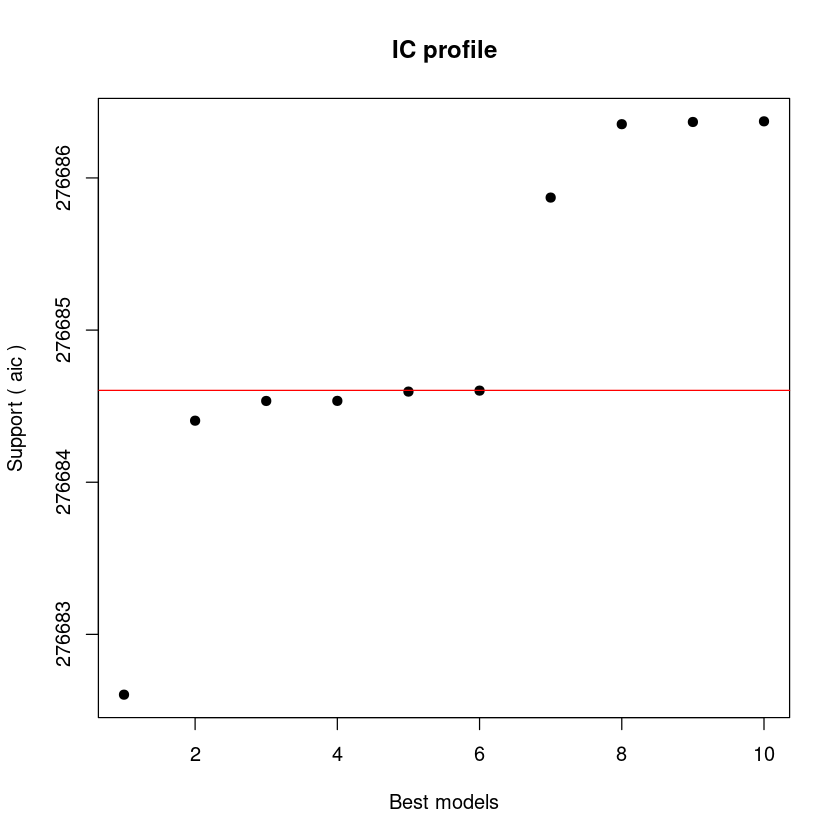

In [55]:
par_function("weight")

[1] "plot_id"          "species_id"       "V1"               "record_id"       
 [5] "month"            "day"              "year"             "sex"             
 [9] "hindfoot_length"  "weight"           "genus"            "species"         
[13] "taxa"             "plot_type"        "dist_from_river"  "surface_terriere"
[17] "dbh"              "age"              "height"           "pc_conif"

### An even better option

In [14]:
#list of variables
yvar.list<-list("hindfoot_length", "weight") # 3 response variables
xvar<-"dist_from_river+dbh+height+surface_terriere+pc_conif"# several explanatory variables which will be combined later
output.list=list()

Initialization...
TASK: Exhaustive screening of candidate set.
Fitting...

After 50 models:
Best model: hindfoot_length~1
Crit= 211544.152055954
Mean crit= 211546.433166666
Completed.
Initialization...
TASK: Exhaustive screening of candidate set.
Fitting...

After 50 models:
Best model: weight~1
Crit= 276682.603722263
Mean crit= 276685.02390673


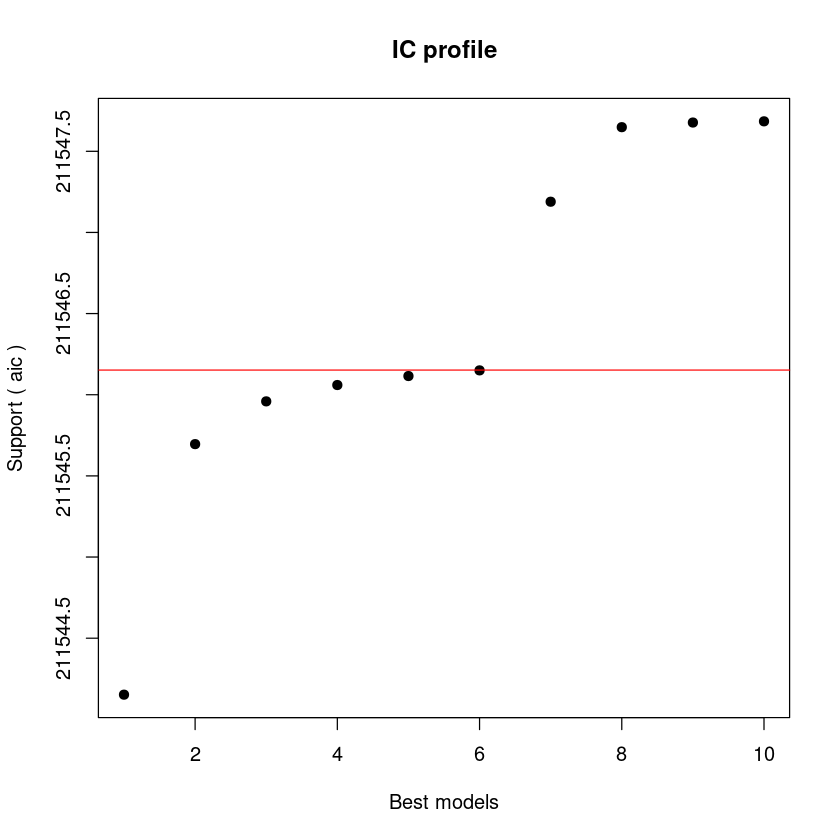

Completed.
Time difference of 16.10801 secs


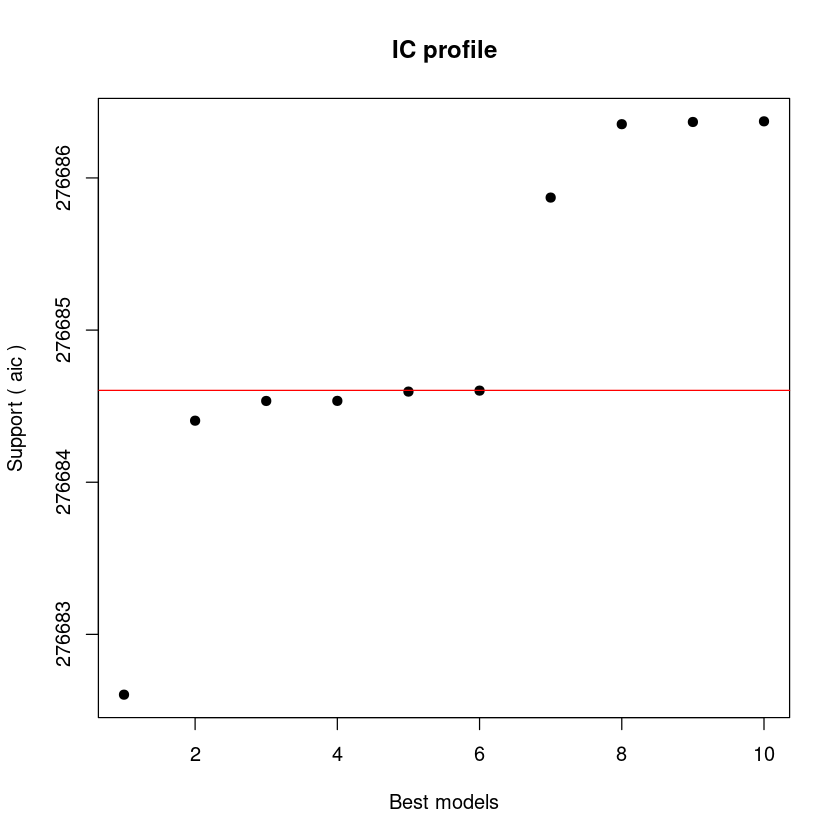

In [86]:
t.st<-Sys.time()
for(y in yvar.list){
  out<-glmulti(formula(paste(y, "dist_from_river+dbh+height+surface_terriere+pc_conif", sep="~")), 
                data=survey_df, random="+(1|plot_id)", fitfunc=lmer.wrap, intercept=TRUE, confsetsize = 10, level=1)
  output.list[[y]]<-out@objects[[1]]
}
t.fin<-Sys.time()
print(t.fin-t.st)

In [15]:
output.list

list()

### We can make it even better by using all available resources

In [16]:
# cluster creation
#library(Rmpi)
library(snow)
library(doSNOW)
library(foreach)

Loading required package: foreach
Loading required package: iterators


In [17]:
# Single node
library(doParallel)
cl<-makeCluster(8)
registerDoParallel(cl)

Loading required package: parallel

Attaching package: ‘parallel’

The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster



In [18]:
# Export variables and libraries
out <- clusterEvalQ(cl, library(rJava))
out <- clusterEvalQ(cl, library(glmulti))
out <- clusterEvalQ(cl, library(lme4))
out <- clusterExport(cl, 'lmer.wrap')
out <- clusterExport(cl, 'glmulti')
out <- clusterExport(cl, 'survey_df')
out <- clusterExport(cl, 'yvar.list')
out <- clusterExport(cl, 'xvar')

In [19]:
foreach.loop<-foreach(y=yvar.list, .combine="cbind") %dopar% par_function(y)
saveRDS(foreach.loop, 'output_foreach.rds')

In [20]:
#####################
# delete cluster
#####################
stopCluster(cl)

In [27]:
con <- gzfile("output_foreach.rds")
readRDS(con)
close(con)

In [28]:
con

     description            class             mode             text 
          "rval" "textConnection"              "w"           "text" 
          opened         can read        can write 
        "opened"             "no"            "yes" 

# If you are running your script on our servers


In [ ]:
nCore = as.integer(Sys.getenv("MOAB_PROCCOUNT"))
if (is.na(nCore)){ nCore = 8 }

# Multiple nodes
cl = makeMPIcluster(nCore)
registerDoSNOW(cl)